# attention mechanism

注意力是稀缺的，而环境中的干扰注意力的信息却并不少。
比如人类的视觉神经系统大约每秒收到$10^8$位的信息，
这远远超过了大脑能够完全处理的水平。
幸运的是，人类的祖先已经从经验（也称为数据）中认识到
“并非感官的所有输入都是一样的”。
在整个人类历史中，这种只将注意力引向感兴趣的一小部分信息的能力，
使人类的大脑能够更明智地分配资源来生存、成长和社交，
例如发现天敌、找寻食物和伴侣。

## 生物学中的注意力提示

注意力是如何应用于视觉世界中的呢？
这要从当今十分普及的*双组件*（two-component）的框架开始讲起：
这个框架的出现可以追溯到19世纪90年代的威廉·詹姆斯，
他被认为是“美国心理学之父” :cite:`James.2007`。
在这个框架中，受试者基于*非自主性提示*和*自主性提示*
有选择地引导注意力的焦点。

非自主性提示是基于环境中物体的突出性和易见性。
想象一下，假如我们面前有五个物品：
一份报纸、一篇研究论文、一杯咖啡、一本笔记本和一本书，
所有纸制品都是黑白印刷的，但咖啡杯是红色的。
换句话说，这个咖啡杯在这种视觉环境中是突出和显眼的，
不由自主地引起人们的注意。
所以我们会把视力最敏锐的地方放到咖啡上

喝咖啡后，我们会变得兴奋并想读书，
所以转过头，重新聚焦眼睛，然后看看书，
此时选择书是受到了认知和意识的控制，
因此注意力在基于自主性提示去辅助选择时将更为谨慎。
受试者的主观意愿推动，选择的力量也就更强大。

## 查询、键和值

自主性的与非自主性的注意力提示解释了人类的注意力的方式，
下面来看看如何通过这两种注意力提示，
用神经网络来设计注意力机制的框架，

首先，考虑一个相对简单的状况，
即只使用非自主性提示。
要想将选择偏向于感官输入，
则可以简单地使用参数化的全连接层，
甚至是非参数化的最大汇聚层或平均汇聚层。

因此，“是否包含自主性提示”将注意力机制与全连接层或汇聚层区别开来。
在注意力机制的背景下，自主性提示被称为*查询*（query）。
给定任何查询，注意力机制通过*注意力汇聚*（attention pooling）
将选择引导至*感官输入*（sensory inputs，例如中间特征表示）。
在注意力机制中，这些感官输入被称为*值*（value）。
更通俗的解释，每个值都与一个*键*（key）配对，
这可以想象为感官输入的非自主提示。
可以通过设计注意力汇聚的方式，
便于给定的查询（自主性提示）与键（非自主性提示）进行匹配，
这将引导得出最匹配的值（感官输入）。

## 注意力的可视化

平均汇聚层可以被视为输入的加权平均值，
其中各输入的权重是一样的。
实际上，注意力汇聚得到的是加权平均的总和值，
其中权重是在给定的查询和不同的键之间计算得出的。

In [1]:
import torch
from d2l import torch as d2l

为了可视化注意力权重，需要定义一个`show_heatmaps`函数。
其输入`matrices`的形状是
（要显示的行数，要显示的列数，查询的数目，键的数目）。

In [2]:
#@save
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds'):
    """显示矩阵热图"""
    d2l.use_svg_display()
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6);

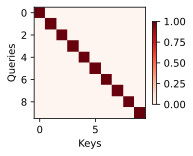

In [3]:
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

# 注意力汇聚：Nadaraya-Watson 核回归


上节介绍了框架下的注意力机制的主要成分;
查询（自主提示）和键（非自主提示）之间的交互形成了注意力汇聚；
注意力汇聚有选择地聚合了值（感官输入）以生成最终的输出。
本节将介绍注意力汇聚的更多细节，
以便从宏观上了解注意力机制在实践中的运作方式。
具体来说，1964年提出的Nadaraya-Watson核回归模型
是一个简单但完整的例子，可以用于演示具有注意力机制的机器学习。

In [4]:
import torch
from torch import nn
from d2l import torch as d2l

## [**生成数据集**]

简单起见，考虑下面这个回归问题：
给定的成对的“输入－输出”数据集
$\{(x_1, y_1), \ldots, (x_n, y_n)\}$，
如何学习$f$来预测任意新输入$x$的输出$\hat{y} = f(x)$？

根据下面的非线性函数生成一个人工数据集，
其中加入的噪声项为$\epsilon$：

$$y_i = 2\sin(x_i) + x_i^{0.8} + \epsilon,$$

其中$\epsilon$服从均值为$0$和标准差为$0.5$的正态分布。
在这里生成了$50$个训练样本和$50$个测试样本。
为了更好地可视化之后的注意力模式，需要将训练样本进行排序。


In [5]:
n_train = 50  # 训练样本数
x_train, _ = torch.sort(torch.rand(n_train) * 5)   # 排序后的训练样本

In [6]:
def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # 训练样本的输出
x_test = torch.arange(0, 5, 0.1)  # 测试样本
y_truth = f(x_test)  # 测试样本的真实输出
n_test = len(x_test)  # 测试样本数
n_test

50

下面的函数将绘制所有的训练样本（样本由圆圈表示），
不带噪声项的真实数据生成函数$f$（标记为“Truth”），
以及学习得到的预测函数（标记为“Pred”）。

In [8]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

## 平均汇聚

先使用最简单的估计器来解决回归问题。
基于平均汇聚来计算所有训练样本输出值的平均值：

$$f(x) = \frac{1}{n}\sum_{i=1}^n y_i,$$

真实函数$f$（“Truth”）和预测函数（“Pred”）相差很大。

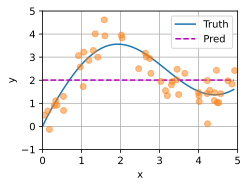

In [9]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

## [**非参数注意力汇聚**]

显然，平均汇聚忽略了输入$x_i$。
于是`Nadaraya.1964`和
`Watson.1964`提出了一个更好的想法，
根据输入的位置对输出$y_i$进行加权：

$$f(x) = \sum_{i=1}^n \frac{K(x - x_i)}{\sum_{j=1}^n K(x - x_j)} y_i,$$


其中$K$是*核*（kernel）。
公式 `eq_nadaraya-watson`所描述的估计器被称为
*Nadaraya-Watson核回归*（Nadaraya-Watson kernel regression）。
受此启发，
我们可以得到更加通用的*注意力汇聚*（attention pooling）公式：
$$f(x) = \sum_{i=1}^n \alpha(x, x_i) y_i,$$

其中$x$是查询，$(x_i, y_i)$是键值对。
比较 `eq_attn-pooling`和 `eq_avg-pooling`，
注意力汇聚是$y_i$的加权平均。
将查询$x$和键$x_i$之间的关系建模为
*注意力权重*（attention weight）$\alpha(x, x_i)$，
如 `eq_attn-pooling`所示，
这个权重将被分配给每一个对应值$y_i$。
对于任何查询，模型在所有键值对注意力权重都是一个有效的概率分布：
它们是非负的，并且总和为1。

为了更好地理解注意力汇聚，
下面考虑一个*高斯核*（Gaussian kernel），其定义为：

$$K(u) = \frac{1}{\sqrt{2\pi}} \exp(-\frac{u^2}{2}).$$

将高斯核代入 `eq_attn-pooling`和
 `eq_nadaraya-watson`可以得到：

$$\begin{aligned} f(x) &=\sum_{i=1}^n \alpha(x, x_i) y_i\\ &= \sum_{i=1}^n \frac{\exp\left(-\frac{1}{2}(x - x_i)^2\right)}{\sum_{j=1}^n \exp\left(-\frac{1}{2}(x - x_j)^2\right)} y_i \\&= \sum_{i=1}^n \mathrm{softmax}\left(-\frac{1}{2}(x - x_i)^2\right) y_i. \end{aligned}$$


如果一个键$x_i$越是接近给定的查询$x$，
那么分配给这个键对应值$y_i$的注意力权重就会越大，
也就“获得了更多的注意力”。

值得注意的是，Nadaraya-Watson核回归是一个非参数模型。
因此，`eq_nadaraya-watson-gaussian`是
*非参数的注意力汇聚*（nonparametric attention pooling）模型。
接下来，我们将基于这个非参数的注意力汇聚模型来绘制预测结果。
从绘制的结果会发现新的模型预测线是平滑的，并且比平均汇聚的预测更接近真实。


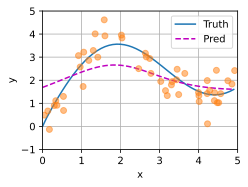

In [10]:
# X_repeat的形状:(n_test,n_train),
# 每一行都包含着相同的测试输入（例如：同样的查询）
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# x_train包含着键。attention_weights的形状：(n_test,n_train),
# 每一行都包含着要在给定的每个查询的值（y_train）之间分配的注意力权重
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

现在来观察注意力的权重。
这里测试数据的输入相当于查询，而训练数据的输入相当于键。
因为两个输入都是经过排序的，因此由观察可知“查询-键”对越接近，
注意力汇聚的[**注意力权重**]就越高。

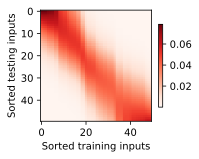

In [11]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')